Total sequences loaded: 7200634
Min sequence length: 101
Max sequence length: 377
Average sequence length: 229.98

Header: PRJNA975614|SRR24714864|human|AAGCCGCAGGACACCA|IGHV3-15*01,IGHD6-6*01,IGHJ6*02,IGHM|IGLV1-36*01,IGLJ3*02,IGLC2|TTDHPSSIAARLGESYYYGMDV|AAWDDSLNGPV
Sequence: EVQLVESGGGLVKPGGSLRLSCAASGFTFSNAWMNWVRQAPGKGLQWVGRIKSKSDGGTTHYAAPVKGRFTILRDDSKNTLYLQMNSLKTEDTAVYYCTTDHPSSIAARLGESYYYGMDVWGQGTTVTVSS/QSVLTQPPSVSEAPRQRVTISCSGSSSNIGNNAVNWYQQLPGKAPKLLIYYDDLLPSGVSDRFSGSKSGTSASLAISGLQSEDEADYYCAAWDDSLNGPVFGGGTKLTVL

Header: PRJNA975614|SRR24714864|human|ATCCGAAAGGGAGTAA|IGHV4-59*01,IGHJ4*02,IGHM|IGLV7-46*04,IGLJ3*02,IGLC3|ARDRYFDY|LLSYSGARV
Sequence: QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLEWIGCIYYSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARDRYFDYWGQGTLVTVSS/QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAPRTLIYDTSNKHSWTPARFSGSLLGGKAALTLSGAQPEDEAEYYCLLSYSGARVFGGGTKLTVL

Header: PRJNA975614|SRR24714864|human|CAGACGACAAACCTAC|IGHV4-39*01,IGHD3-10*01,IGHJ6*02,IGHG1|IGKV4-1*01,IGKJ4*01,

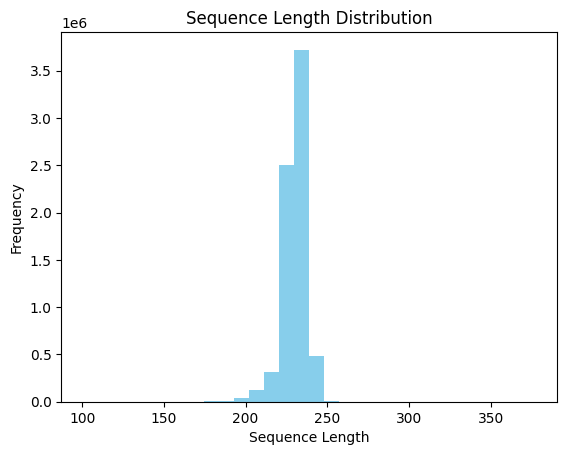

In [2]:
import os
from Bio import SeqIO
import matplotlib.pyplot as plt

folder_path = "paired_fasta"
sequences = []
lengths = []
headers = []

for filename in os.listdir(folder_path):
    if filename.endswith(".fasta") or filename.endswith(".fa"):
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                sequences.append(str(record.seq))
                lengths.append(len(record.seq))
                headers.append(record.description)

print(f"Total sequences loaded: {len(sequences)}")

# Show length stats
print(f"Min sequence length: {min(lengths)}")
print(f"Max sequence length: {max(lengths)}")
print(f"Average sequence length: {sum(lengths)/len(lengths):.2f}")

# Show 5 sample headers and sequences
for i in range(5):
    print(f"\nHeader: {headers[i]}\nSequence: {sequences[i]}")

# Plot length distribution
plt.hist(lengths, bins=30, color='skyblue')
plt.title("Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import os
from Bio import SeqIO

folder_path = "paired_fasta"
cdr_data = []  # will hold tuples like (record_id, cdr_sequence)

for filename in os.listdir(folder_path):
    if filename.endswith(".fasta") or filename.endswith(".fa"):
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                header = record.description
                parts = header.split('|')
                
                # Example: Assume the second last pipe-separated field is CDR3 (adjust if needed)
                if len(parts) >= 2:
                    cdr = parts[-2]  # You might want to verify which part is the CDR
                    cdr_data.append((record.id, cdr))

print(f"Extracted {len(cdr_data)} CDR sequences.")

# Show sample
for i in range(5):
    print(f"ID: {cdr_data[i][0]}, CDR: {cdr_data[i][1]}")


Extracted 7200634 CDR sequences.
ID: PRJNA975614|SRR24714864|human|AAGCCGCAGGACACCA|IGHV3-15*01,IGHD6-6*01,IGHJ6*02,IGHM|IGLV1-36*01,IGLJ3*02,IGLC2|TTDHPSSIAARLGESYYYGMDV|AAWDDSLNGPV, CDR: TTDHPSSIAARLGESYYYGMDV
ID: PRJNA975614|SRR24714864|human|ATCCGAAAGGGAGTAA|IGHV4-59*01,IGHJ4*02,IGHM|IGLV7-46*04,IGLJ3*02,IGLC3|ARDRYFDY|LLSYSGARV, CDR: ARDRYFDY
ID: PRJNA975614|SRR24714864|human|CAGACGACAAACCTAC|IGHV4-39*01,IGHD3-10*01,IGHJ6*02,IGHG1|IGKV4-1*01,IGKJ4*01,IGKC|ASGLSYGSGSYGGMDV|QQCFSVPLT, CDR: ASGLSYGSGSYGGMDV
ID: PRJNA975614|SRR24714864|human|GACGGCTAGGCATTGG|IGHV3-7*03,IGHD2-15*01,IGHJ4*02,IGHM|IGKV2-28*01,IGKJ3*01,IGKC|VGCSGGRCSDFDY|MQALQTPFT, CDR: VGCSGGRCSDFDY
ID: PRJNA975614|SRR24714864|human|GATTCAGTCCAAACTG|IGHV1-46*03,IGHD1-26*01,IGHJ4*02|IGLV3-1*01,IGLJ2*01,IGLC2|VRGVIHSGSFRASFFDY|QAWDSNTEV, CDR: VRGVIHSGSFRASFFDY


In [1]:
import os
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.cluster import MiniBatchKMeans

# Step 1: Extract CDR sequences from FASTA headers
folder_path = "paired_fasta"
cdr_data = []

for filename in os.listdir(folder_path):
    if filename.endswith(".fasta") or filename.endswith(".fa"):
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                header = record.description
                parts = header.split('|')
                if len(parts) >= 2:
                    cdr = parts[-2]  # adjust if needed
                    cdr_data.append((record.id, cdr))

print(f"Extracted {len(cdr_data)} CDR sequences.")

# Step 2: Clean CDR sequences
def is_valid_cdr(seq):
    return 5 <= len(seq) <= 30 and all(c in "ACDEFGHIKLMNPQRSTVWY" for c in seq)

clean_cdrs = [(rid, cdr) for rid, cdr in cdr_data if is_valid_cdr(cdr)]
print(f"Filtered to {len(clean_cdrs)} valid CDR sequences.")

# Step 3: Prepare sequences for vectorization
cdr_sequences = [cdr for _, cdr in clean_cdrs]

def kmerize(seq, k=3):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

kmer_sequences = [' '.join(kmerize(seq, 3)) for seq in cdr_sequences]

# Step 4: Vectorize with CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(kmer_sequences)
print(f"Vectorized sequences shape: {X.shape}")

# Step 5: Sample and cluster
total_seqs = X.shape[0]
sample_size = 10000  # adjust to your memory
np.random.seed(42)
random_indices = np.random.choice(total_seqs, size=sample_size, replace=False)
X_sample = X[random_indices]

n_clusters = 10
mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000, random_state=42)
labels_sample = mbk.fit_predict(X_sample)

print(f"Clustered {sample_size} sequences into {n_clusters} clusters.")


Extracted 7200634 CDR sequences.
Filtered to 7181154 valid CDR sequences.
Vectorized sequences shape: (7181154, 8000)
Clustered 10000 sequences into 10 clusters.


In [17]:
from collections import Counter

cluster_counts = Counter(labels_sample)
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} sequences")


Cluster 0: 6573 sequences
Cluster 6: 1935 sequences
Cluster 9: 746 sequences
Cluster 7: 245 sequences
Cluster 2: 103 sequences
Cluster 8: 393 sequences
Cluster 3: 2 sequences
Cluster 1: 1 sequences
Cluster 5: 1 sequences
Cluster 4: 1 sequences


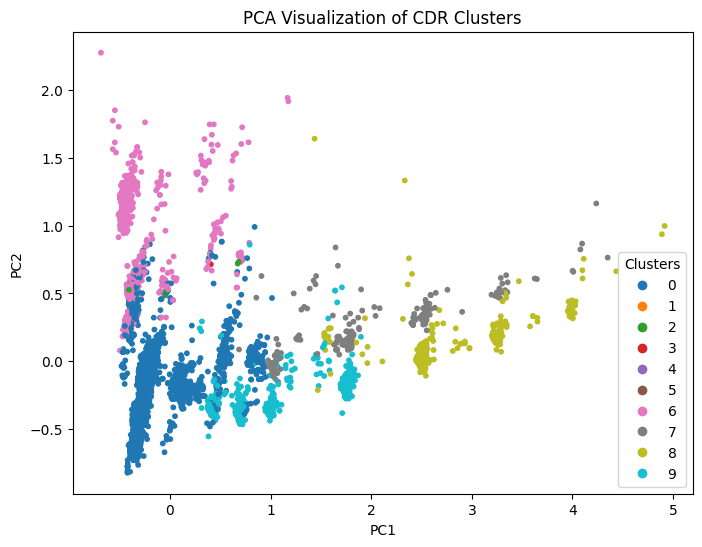

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_sample.toarray())

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels_sample, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("PCA Visualization of CDR Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [19]:
import pandas as pd

sample_ids = [clean_cdrs[i][0] for i in random_indices]
sample_cdrs = [clean_cdrs[i][1] for i in random_indices]

df = pd.DataFrame({
    "ID": sample_ids,
    "CDR": sample_cdrs,
    "Cluster": labels_sample
})

df.to_csv("cdr_clusters_10k.csv", index=False)
print("Saved cluster assignments to cdr_clusters_10k.csv")


Saved cluster assignments to cdr_clusters_10k.csv
